In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import theano as T
import theano.tensor as tt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
from scipy import VisibleDeprecationWarning
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning) 

import pymc3 as pm
import scipy as sp

Imagine water distributed in 5 buckets with the starting distribution equal to [1,0,0,0,0]. Over time the water transitsions to the other buckets following some state dynamic $\rho_0$. For this example let $\rho_0$ equal
$$
\rho_0  = \left[\begin{array}{ccccc}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
\end{array}\right] + 
\left[\begin{array}{ccccc}
.5 & .05 & .1 & .2 & .05 \\
.5 & .05 & .1 & .2 & .05 \\
.5 & .05 & .1 & .2 & .05 \\
.5 & .05 & .1 & .2 & .05 \\
.5 & .05 & .1 & .2 & .05 \\
\end{array}\right] + 
\nu_t
$$

In [2]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)

rho_0 = 25*np.eye(N) + np.concatenate([[[.5],[.05],[.1],[.2],[.05]] for i in range(N)], axis=1)

for i in timesteps:
    
    delta = rho_0 + np.random.normal([0,0,0,0,0], 0.2*np.ones(N))
    delta = delta/np.sum(delta, axis=0)       
    water.append(delta.dot(water[i-1]))
    
water = np.array(water)

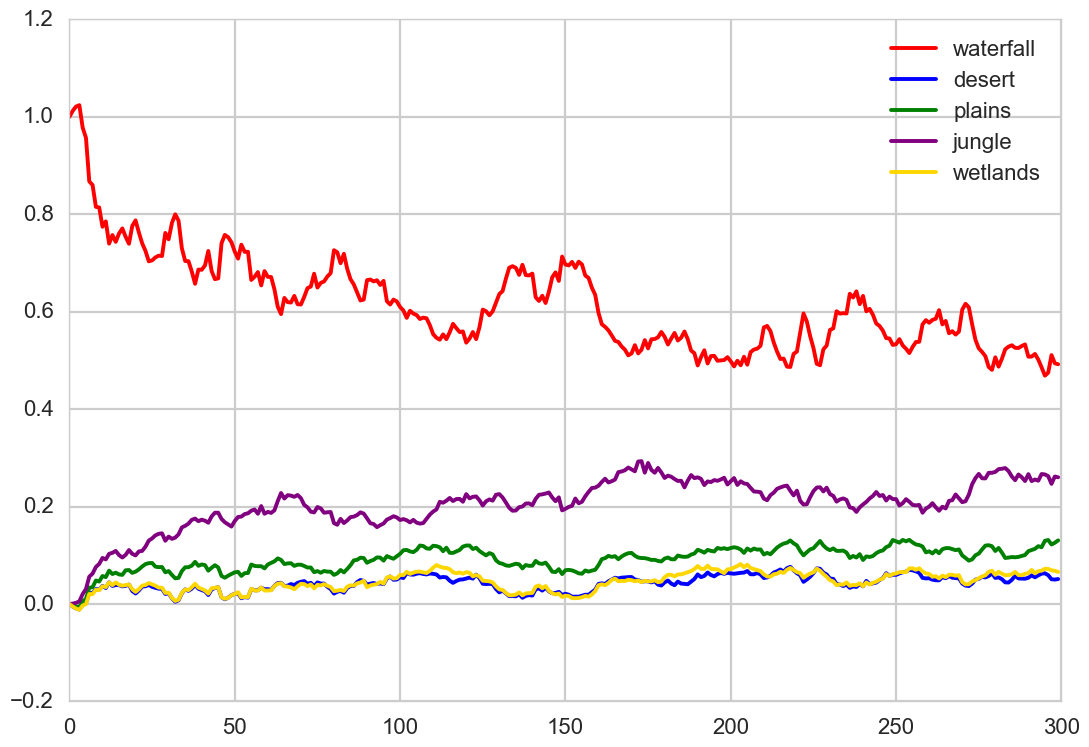

In [3]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], label=labels[i], c=c[i])

plt.legend(loc='best')
plt.show()

Now imagine the same scenario but at some changepoint, the plan changes to a different plan (say to distribute the water equally among the buckets)

In [4]:
water = [np.array([1,0,0,0,0])]
N = 5
timesteps = np.arange(1,5*60)

rho_0 = 25*np.eye(N) + np.array([[.5,.05,.1,.2,.05] for i in range(N)])
rho_1 = 25*np.eye(N) + np.array([[.12,.22,.22,.22,.22] for i in range(N)])
count = 0
rho = rho_0

for i in timesteps:
    
    p = np.random.binomial(n=1, p=1/60)
    
    if p:
        if count == 0:
            count += 1
            print(i)
            rho = rho_1
    
    delta = rho + np.random.normal([0,0,0,0,0], 0.2*np.ones(N))
    delta = delta/np.sum(delta, axis=1)       
    water.append(water[i-1].dot(delta))
    
water = np.array(water)

79


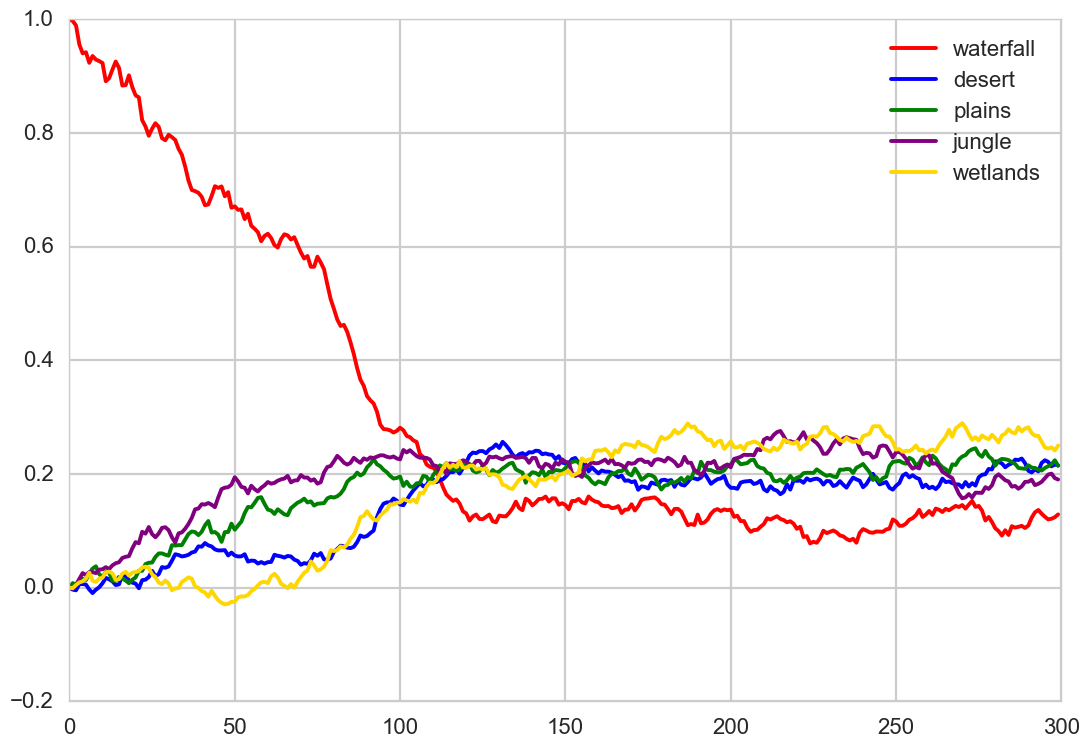

In [5]:
fig, ax = plt.subplots(1,1)

c = ['r', 'b', 'g', 'purple', 'gold']
labels=['waterfall', 'desert', 'plains', 'jungle', 'wetlands']
for i in range(len(water[0])):
    ax.plot(water[:,i], label=labels[i], c=c[i])

plt.legend(loc='best')
plt.show()

In [6]:
df = pd.read_csv('./log-0-Free_Play_for_research.csv')
df = df.iloc[5:]
df.columns = df.columns.str.strip()
df = df[['Desert_Water', 'Jungle_Water', 'Plains_Water', 'Wetlands_Water']]
df['Other_Water'] = 2.5-df.sum(axis=1)
df = df 

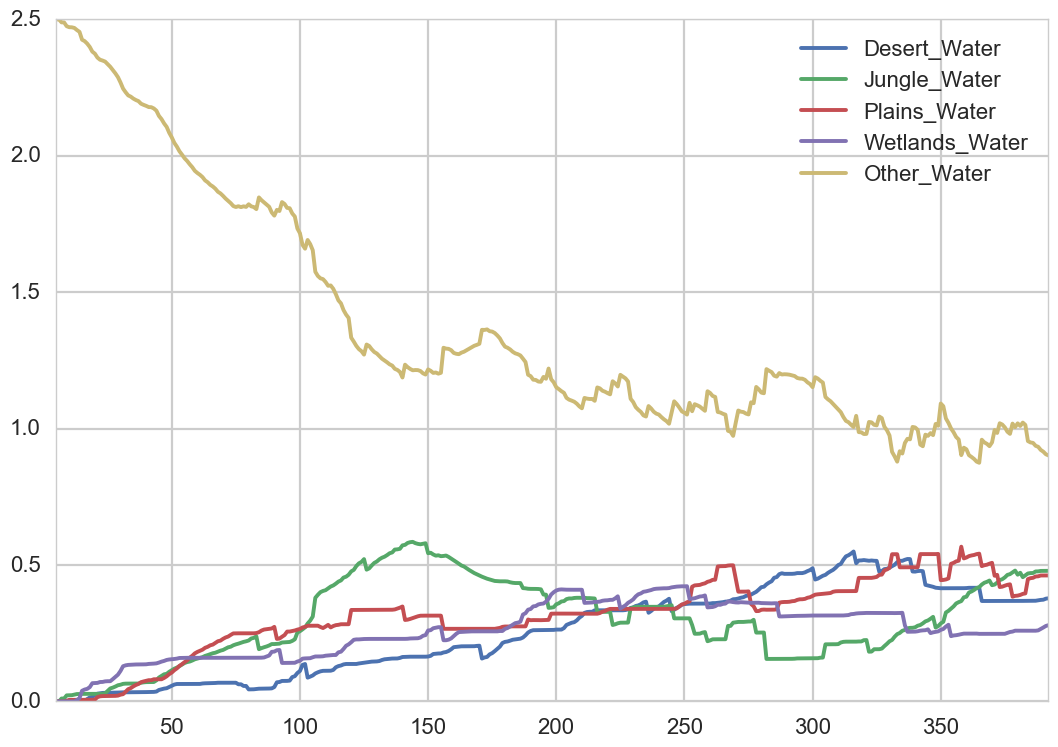

In [7]:
df.plot()

In [8]:
Y = df.values
df.head()

,Desert_Water,Jungle_Water,Plains_Water,Wetlands_Water,Other_Water
5,0.0,0.000000,0.000000,0.0,2.500000
6,0.0,0.000045,0.000000,0.0,2.499955
7,0.0,0.010686,0.000000,0.0,2.489314
8,0.0,0.010910,0.000045,0.0,2.489045
9,0.0,0.022242,0.002576,0.0,2.475181


# Apply the Newton-Raphson (then maybe Baum-Welsh)

We need the complete data likelihood of observing this data. This can be written in terms of the innovations: $\epsilon_t = y_t - A_tx_t^{-1}-\Gamma u_t$. For now let's assume that the user input $u_t$ are wrapped into the system dynamics $A_tx_t^{-1}$. The innovations form the likelihood of the data $y_{1:n}$.

We need the following definitions of the variables:

$\Theta$ is the vector of unknown parameters. This includes $\mu_0$, $\Sigma_0$, the transition matrix $\Phi$ and the state and observation covariance matrices $Q$ and $R$, more generally we also have the input coefficient matrices $\Gamma$ and $\Upsilon$.

I have followed the notation and procedures that Shumway and Stoffer use in *[Schlittgen, R., 2008. Robert H. Shumway and David S. Stoffer: Time series analysis and its applications with R examples, 2nd edn. AStA Advances in Statistical Analysis, 92(2), pp.233–234.]*

We further need the follow notation conveniences:
$$
x_t^s = E(x_t \vert y_{1:s})
$$

i.e. the expected value for the state at time $t$ that depends on the observations $y_1, \dots, y_s$.

$$
P_{t_1, t_2}^s = E[(x_{t_1} - x_{t_1}^s)(x_{t_2} - x_{t_2}^s)^T)
$$

i.e. the covariance matrix of two observations at different times. $P_{t}^s$ is used to denote the covariance of the data for $t_1 = t_2 = t$.

The innovations are independent Gaussian random vectors with zero means and covariance matrices:

$$
\Sigma_t = A_tP^{t-1}_{t}A_t^T + R
$$

The likelihood of observing the parameters $\Theta$, $L_Y(\Theta)$, can be written as:

$$
-lnL_Y(\Theta) = \frac{1}{2} \sum\limits_{t=1}^{n} ln \vert \Sigma_t(\Theta) \vert + \frac{1}{2} \sum_{t=1}^{n} \epsilon_t(\Theta)^T \Sigma_t (\Theta)^{-1} \epsilon_t(\Theta)
$$

### What is the specific model that we have here?

$$
x_t = \Phi x_{t-1} + \mathcal{N}_p(0, Q)
$$

$$
y_t^{(k)} = x_{t}^{(k)}
$$

$\Phi$ is the auto-regressive parameter that describes the state transitsions. $Q$ is the covariance of the noise in the system. Notice, that the observations are direct mappings of the states without any associated noise.

$$
\Sigma_t (\Theta) = A_t P_t^{t-1}A_t^T + R = P_t^{t-1} = \Phi P_{t-1}^{t-1} \Phi^T + Q
$$

#### We need a forward Kalman Filter to achieve this maximisation

$$
x_t^{t-1} = \Phi x_{t-1}^{t-1}
$$

$$
P_t^{t-1} = \Phi P_{t-1}^{t-1} \Phi^T + Q
$$

$$
x_t^t = x_t^{t-1} + K_t \epsilon_t
$$

$$
\epsilon_t = y_t - E(y_t \vert t_{1:t-1}) = y_t - x_t^{t-1}
$$

$$
P_t^{t} = [I - K_t]P_t^{t-1}
$$

Where:

$$
K_t = P_t^{t-1}[P_t^{t-1}+ R]^{-1}
$$

In [209]:
N = 5
X = np.array([2.5,0,0,0,0])
aug_X = np.concatenate([X, np.ones(N)])
learn_rate = .01
target = np.array([.9,.4,.4,.4,.4])
Phi = np.eye(2*N)
Phi[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate
Phi[0:N,N:] = np.diag(target)*learn_rate
Phi.shape

(10, 10)

In [210]:
aug_X = Phi.dot(aug_X)
aug_X

array([ 2.484,  0.004,  0.004,  0.004,  0.004,  1.   ,  1.   ,  1.   ,
        1.   ,  1.   ])

In [211]:
A = np.concatenate([np.eye(N), np.zeros((N,N))], axis=1)
A

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [212]:
def ForwardFilter(y_t, x_tmin1_tmin1, P_tmin1_tmin1, Q, R, Phi):
    
    if x_tmin1_tmin1.shape[0] <= N:
        x_tmin1_tmin1 = np.concatenate([x_tmin1_tmin1, np.ones(N)])
    x_t_tmin1 = Phi.dot(x_tmin1_tmin1)

    # ii - we need the forward Kalman Filter
    x_t_tmin1 = Phi.dot(x_tmin1_tmin1)
    P_t_tmin1 = Phi.dot(P_tmin1_tmin1).dot(Phi.T)
    P_t_tmin1[0:N, 0:N] += Q
    
    sigma_t = A.dot(P_t_tmin1).dot(A.T) + R
    sigma_t_inv = np.linalg.pinv(sigma_t)
    
    K_t = P_t_tmin1.dot(A.T).dot(sigma_t_inv)
    
    epsilon_t = y_t - (A.dot(x_t_tmin1)) # checked

    x_t_t = x_t_tmin1 + K_t.dot(epsilon_t)
    P_t_t = (np.eye(2*N) - K_t.dot(A)).dot(P_t_tmin1)
    
    return (epsilon_t, x_t_t, P_t_t, sigma_t_inv, sigma_t)

In [242]:
def calc_log_likelihood(theta, Y=Y,  x_tmin1_tmin1 = np.concatenate([[2.5,0,0,0,0], np.ones(N)]), return_params = False):
    
    learn_rate = theta[5]
    target = theta[0:5]
    Phi = np.eye(2*N)
    Phi[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate
    Phi[0:N,N:] = np.diag(target)*learn_rate

    Q = np.eye(5) * 1e-3
#     Q[-1,-1] = 0
#     R = np.zeros((N,N)) * 1e-10
    R = np.eye(5)*1e-3
    
    # Initial state conditions
    P_tmin1_tmin1 = np.eye(2*N)
    P_tmin1_tmin1[N:,N:]=0
    y_t = Y[0,:]

    params = {}
    params['x_t'] = []
    params['P_t'] = []
    params['epsilon_t'] = []
    params['sigma_t'] = []
    params['sigma_t_inv'] = []
    params['error_term'] = []

    for i in range(0, len(Y)):

        y_t = Y[i,:]
        (epsilon_t, x_t_t, P_t_t, sigma_t_inv, sigma_t) = ForwardFilter(y_t, x_tmin1_tmin1, P_tmin1_tmin1, Q, R, Phi)
        # update the params
        x_tmin1_tmin1 = x_t_t
        P_tmin1_tmin1 = P_t_t

        params['x_t'].append(x_t_t)
        params['P_t'].append(P_t_t)
        params['epsilon_t'].append(epsilon_t)
        params['sigma_t'].append(sigma_t)
        params['sigma_t_inv'].append(sigma_t_inv)
        params['error_term'].append(epsilon_t.T.dot(sigma_t_inv).dot(epsilon_t))

    neg_log_likelihood = np.sum(np.log(np.linalg.det(params['sigma_t']))) + np.sum(params['error_term'])
    
    if return_params:
        return neg_log_likelihood, params
    
    return neg_log_likelihood

In [243]:
theta_0 = np.array([.5,.5,.5,.5,.5,.01,.1,.1])
calc_log_likelihood(theta_0, Y=Y)

-11330.207161523693

In [244]:
theta_t = theta_0
result = sp.optimize.minimize(calc_log_likelihood,
                              theta_t,
                              options={'maxiter': 200, 'disp': True},
                              args=(Y, np.array([0,0,0,0,2.5]), ))
theta_t1 = result.x

         Current function value: -11353.793457
         Iterations: 20
         Function evaluations: 871
         Gradient evaluations: 86


In [245]:
theta_t1

array([ 0.33818575,  0.40285585,  0.41382754,  0.31718322,  1.02794608,
        0.01196785,  0.1       ,  0.1       ])

In [246]:
neg_, params = calc_log_likelihood(theta_t1, Y, np.array([0,0,0,0,2.5]), return_params=True)

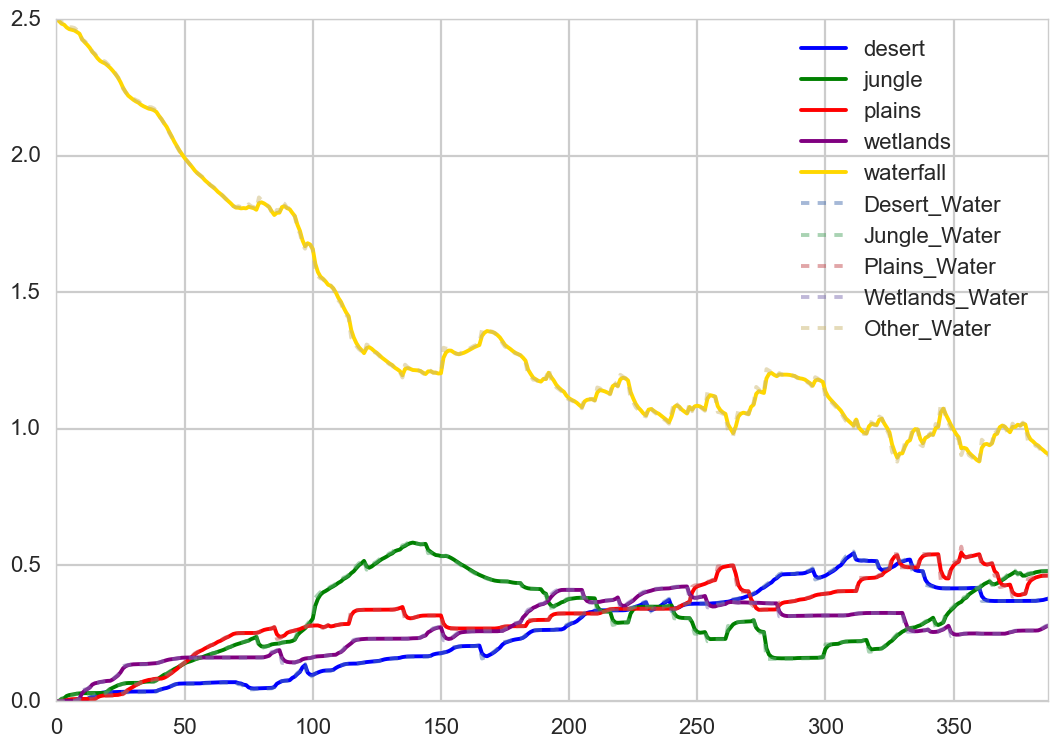

In [247]:
w_1 = np.array(params['x_t'])
fig, ax = plt.subplots(1,1)

c = ['b', 'g', 'r', 'purple', 'gold']
labels=['desert', 'jungle', 'plains', 'wetlands', 'waterfall']
for i in range(N):
    
    ax.plot(w_1[:,i], label=labels[i], c=c[i])
    
df.reset_index(drop=True).plot(ax=ax, ls='--', alpha=0.5)
plt.legend(loc='best')
plt.show()

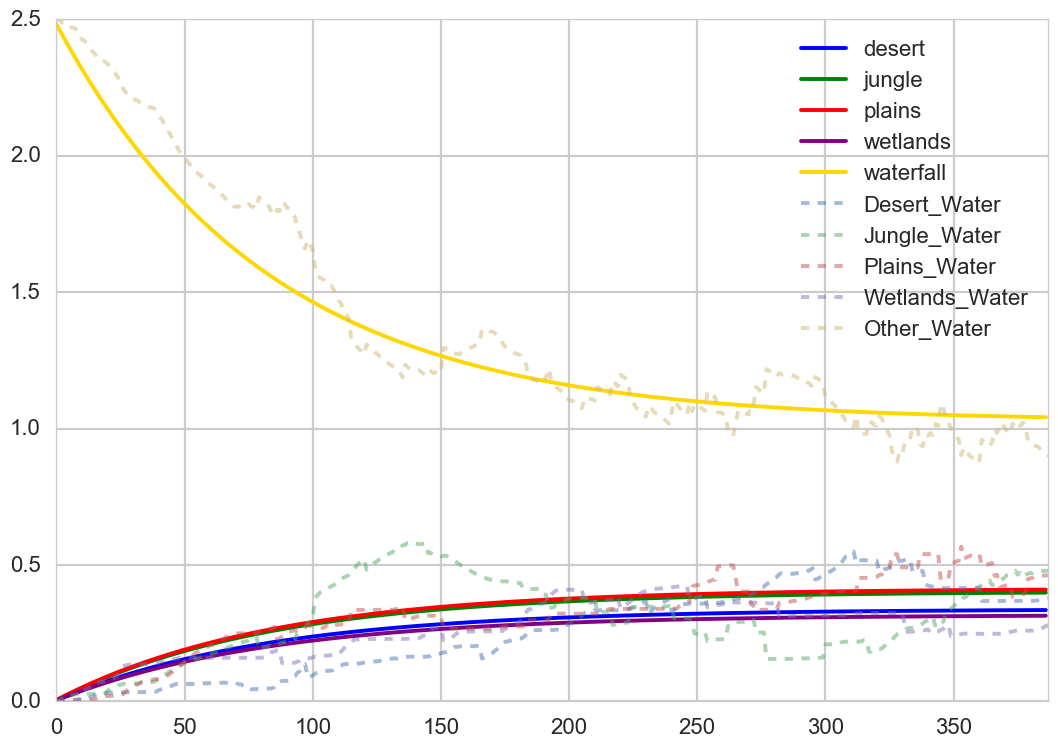

In [248]:
x_0 = np.array([0,0,0,0,2.5])
if x_0.shape[0] <= N:
    x_0 = np.concatenate([x_0, np.ones(N)])

water_ = [x_0]

learn_rate = theta_t1[5]
target = theta_t1[0:5]
Phi = np.eye(2*N)
Phi[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate
Phi[0:N,N:] = np.diag(target)*learn_rate

fig, ax = plt.subplots(1,1)
ys = []

for i in range(1, len(w_1)):
    
    x_t = Phi.dot(water_[i - 1])
    water_.append(x_t)
    ys.append(A.dot(x_t))
    
ys = np.array(ys)

for i in range(5):
    ax.plot(ys[:,i], label=labels[i], c=c[i])

(df).reset_index(drop=True).plot(ax=ax, ls='--', alpha=0.5)
plt.legend(loc='best')
plt.show()

# breakpoint included

In [249]:
cutoff = 150

theta_t = theta_0
result = sp.optimize.minimize(calc_log_likelihood,
                              theta_t,
                              options={'maxiter': 200, 'disp': True},
                              args=(Y[:cutoff,:], np.array([0,0,0,0,2.5]), ))
theta_t1 = result.x

theta_t = theta_t1
result = sp.optimize.minimize(calc_log_likelihood,
                              theta_t,
                              options={'maxiter': 200, 'disp': True},
                              args=(Y[cutoff:,:], np.array([.5,.5,.5,.5,.5]), ))
theta_t2 = result.x

         Current function value: -4400.225284
         Iterations: 17
         Function evaluations: 601
         Gradient evaluations: 59
         Current function value: -6932.600972
         Iterations: 30
         Function evaluations: 471
         Gradient evaluations: 47


In [250]:
x_0 = np.array([0,0,0,0,2.5])
if x_0.shape[0] <= N:
    x_0 = np.concatenate([x_0, np.ones(N)])

water_ = [x_0]

learn_rate1 = theta_t1[5]
target1 = theta_t1[0:5]
Phi1 = np.eye(2*N)
Phi1[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate1
Phi1[0:N,N:] = np.diag(target1)*learn_rate1

learn_rate2 = theta_t2[5]
target2 = theta_t2[0:5]
Phi2 = np.eye(2*N)
Phi2[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate2
Phi2[0:N,N:] = np.diag(target2)*learn_rate2

In [251]:
learn_rate1, target1, learn_rate2, target2

(0.0086263536322604834,
 array([ 0.21707649,  0.67168703,  0.44293917,  0.36777931,  0.80051528]),
 0.037654894420705499,
 array([ 0.39038659,  0.32095306,  0.40617464,  0.32326695,  1.05921868]))

In [252]:
neg_, params1 = calc_log_likelihood(theta_t1, Y[:cutoff,:], np.array([0,0,0,0,2.5]), return_params=True)
neg_, params2 = calc_log_likelihood(theta_t2, Y[cutoff:,:], params1['x_t'][-1], return_params=True)

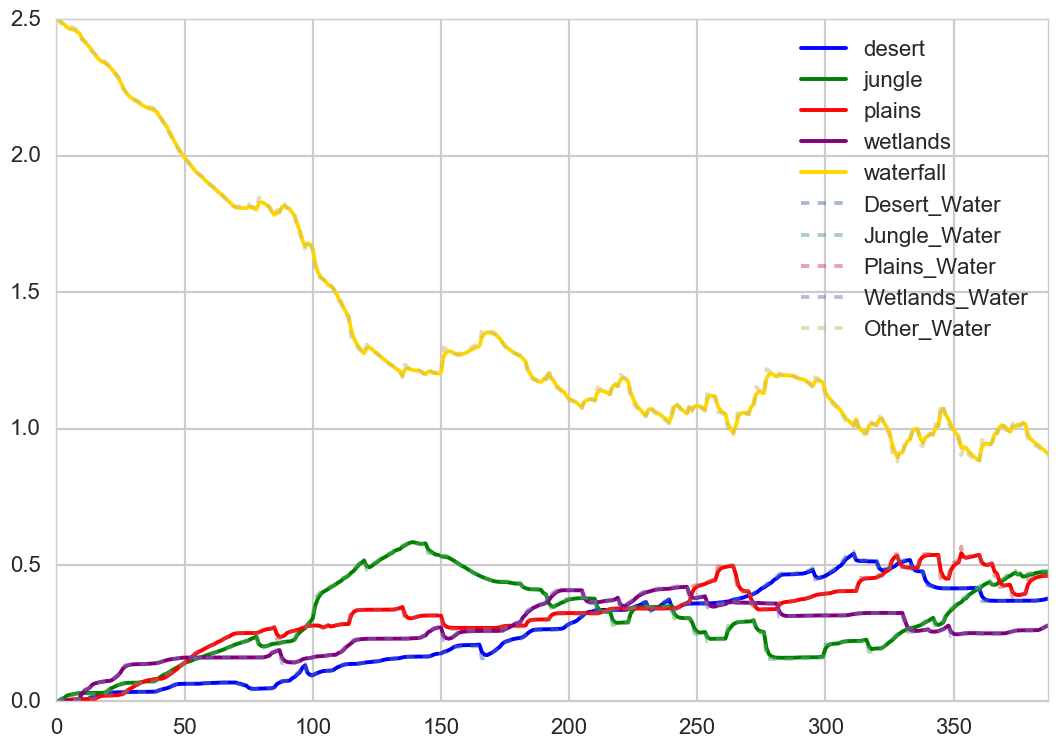

In [253]:
w_1 = np.array(params1['x_t'])
w_2 = np.array(params2['x_t'])

fig, ax = plt.subplots(1,1)

c = ['b', 'g', 'r', 'purple', 'gold']
labels=['desert', 'jungle', 'plains', 'wetlands', 'waterfall']
for i in range(N):
    
    ax.plot(w_1[:,i], label=labels[i], c=c[i])
    ax.plot(np.arange(cutoff, len(df)), w_2[:,i], c=c[i])

df.reset_index(drop=True).plot(ax=ax, ls='--', alpha=0.5)
plt.legend(loc='best')
plt.show()

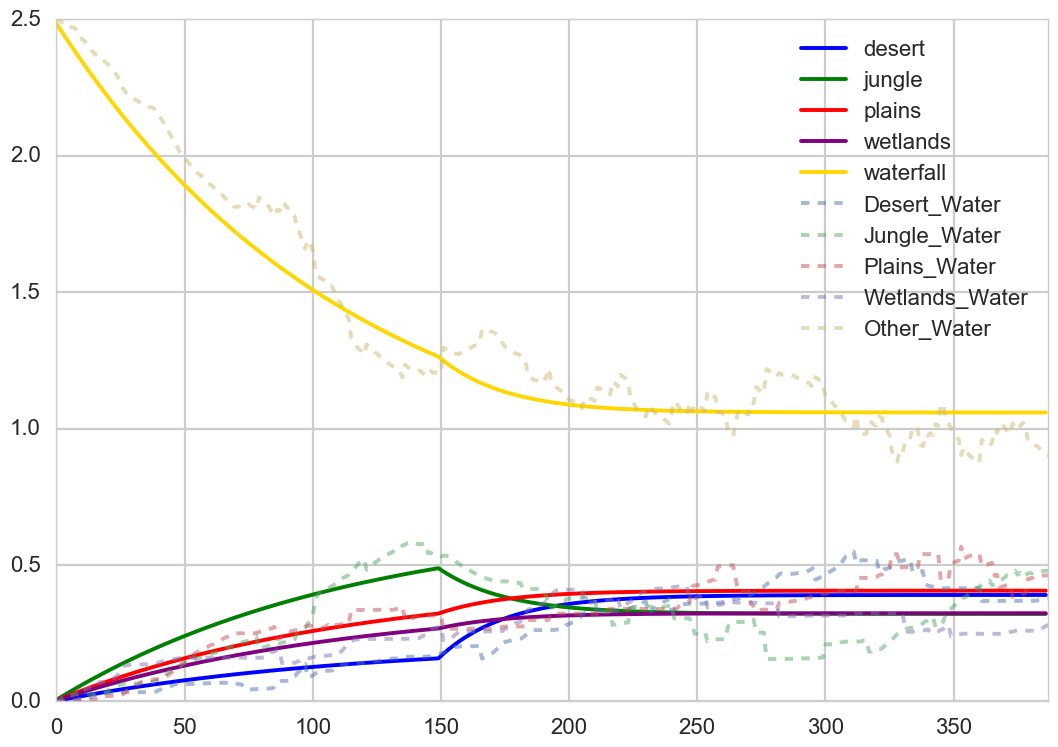

In [254]:
fig, ax = plt.subplots(1,1)
ys = []

x_0 = np.array([0,0,0,0,2.5])
if x_0.shape[0] <= N:
    x_0 = np.concatenate([x_0, np.ones(N)])
water_ = [x_0]
Phi = Phi1
for i in range(1, len(w_1) + len(w_2)):
    
    if i > cutoff:
        Phi = Phi2
        
    x_t = Phi.dot(water_[i - 1])
    water_.append(x_t)
    ys.append(A.dot(x_t))
    
ys = np.array(ys)

for i in range(5):
    ax.plot(ys[:,i], label=labels[i], c=c[i])

(df).reset_index(drop=True).plot(ax=ax, ls='--', alpha=0.5)
plt.legend(loc='best')
plt.show()

### Multiple cutoffs

In [267]:
cutoffs = [0, 140, 225, 320]

theta_t = theta_0
x_0 = np.array([0,0,0,0,2.5])
thetas = []
for i, cutoff in enumerate(cutoffs):
    
    if i == len(cutoffs) - 1:
        c2 = len(Y)
    else:
        c2 = cutoffs[i+1]
        
    theta_t = theta_0
    result = sp.optimize.minimize(calc_log_likelihood,
                                  theta_t,
                                  options={'maxiter': 200, 'disp': True},
                                  args=(Y[cutoff:c2,:], x_0, ))
    x_0 = np.array([.5,.5,.5,.5,.5])
    theta_t = result.x
    thetas.append(theta_t)

         Current function value: -4104.002491
         Iterations: 16
         Function evaluations: 1112
         Gradient evaluations: 110
         Current function value: -2477.974039
         Iterations: 30
         Function evaluations: 501
         Gradient evaluations: 50
         Current function value: -2758.283284
         Iterations: 34
         Function evaluations: 601
         Gradient evaluations: 60
         Current function value: -1957.530242
         Iterations: 27
         Function evaluations: 711
         Gradient evaluations: 70


In [268]:
thetas

[array([ 0.2430918 ,  0.83081712,  0.50295725,  0.38765233,  0.53547644,
         0.00702255,  0.1       ,  0.1       ]),
 array([ 0.2717569 ,  0.38450362,  0.30378291,  0.33617317,  1.20378336,
         0.0751867 ,  0.1       ,  0.1       ]),
 array([ 0.43667534,  0.22566376,  0.4024977 ,  0.34962805,  1.08553514,
         0.09527082,  0.1       ,  0.1       ]),
 array([ 0.40378443,  0.39864856,  0.484183  ,  0.25992008,  0.95346391,
         0.11310529,  0.1       ,  0.1       ])]

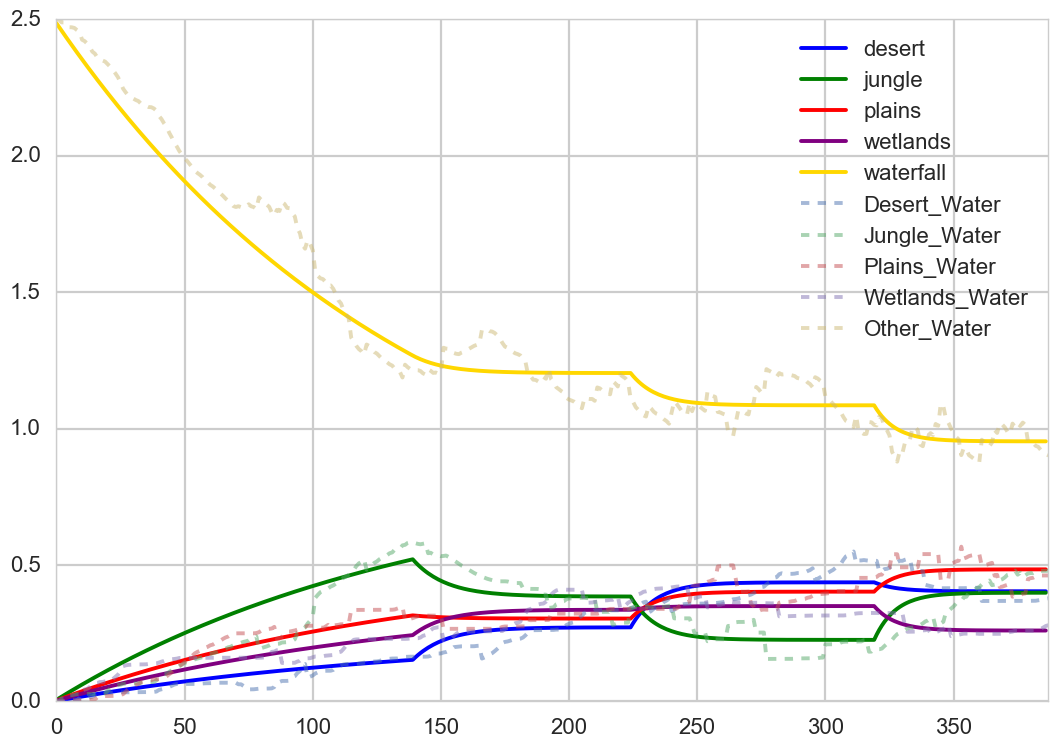

In [269]:
fig, ax = plt.subplots(1,1)
ys = []

x_0 = np.array([0,0,0,0,2.5])
if x_0.shape[0] <= N:
    x_0 = np.concatenate([x_0, np.ones(N)])
water_ = [x_0]

j=0
learn_rate = thetas[j][5]
target = thetas[j][0:5]
Phi = np.eye(2*N)
Phi[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate
Phi[0:N,N:] = np.diag(target)*learn_rate

for i in range(1, len(w_1) + len(w_2)):
    
    if j+1 < len(cutoffs):
        if i > cutoffs[j+1]:
            j += 1
            learn_rate = thetas[j][5]
            target = thetas[j][0:5]
            Phi = np.eye(2*N)
            Phi[0:N, 0:N] = np.eye(N) - np.eye(N)*learn_rate
            Phi[0:N,N:] = np.diag(target)*learn_rate

    x_t = Phi.dot(water_[i - 1])
    water_.append(x_t)
    ys.append(A.dot(x_t))
    
ys = np.array(ys)

for i in range(5):
    ax.plot(ys[:,i], label=labels[i], c=c[i])

(df).reset_index(drop=True).plot(ax=ax, ls='--', alpha=0.5)
plt.legend(loc='best')
plt.show()

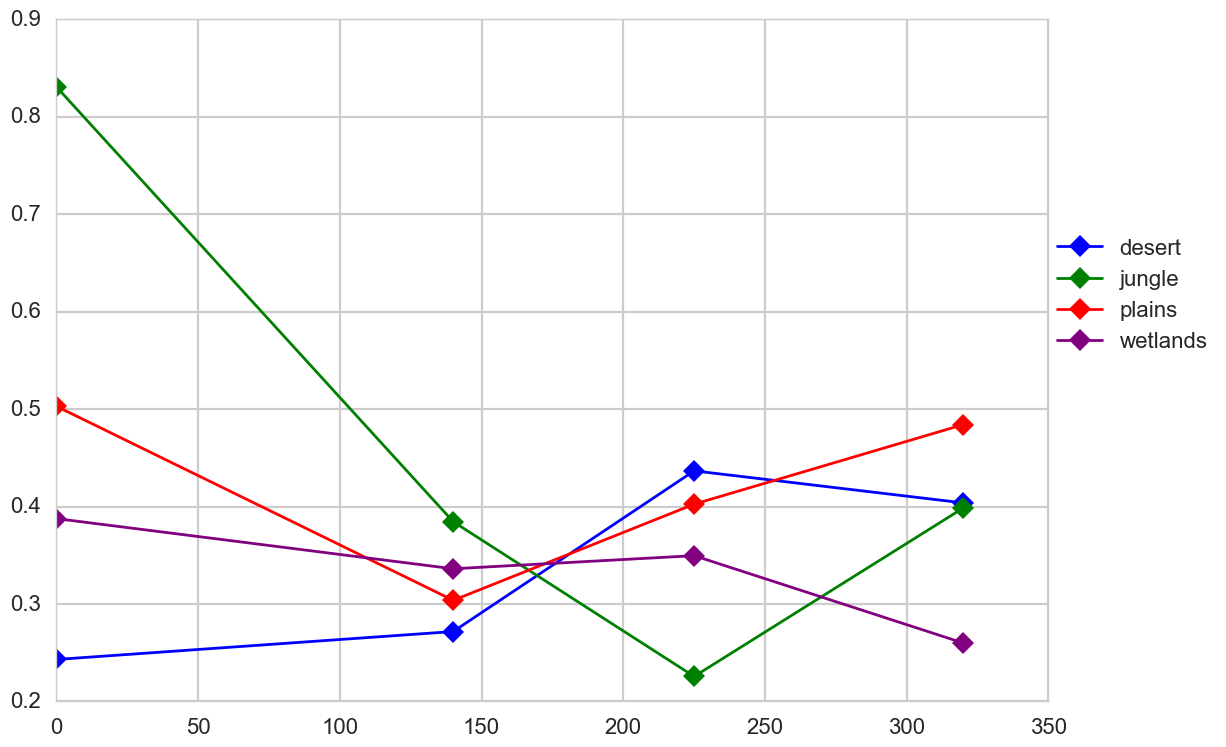

In [270]:
fig, ax = plt.subplots(1,1)

targets = [[],[],[],[],[]]
for i in range(len(cutoffs)):
    
    for j in range(4):
        
        targets[j].append(thetas[i][j])

for i in range(4):  
    ax.plot(cutoffs, targets[i], '-D', c=c[i], label=labels[i], lw=2)
        
ax.legend(loc=[1,0.5])
plt.show()

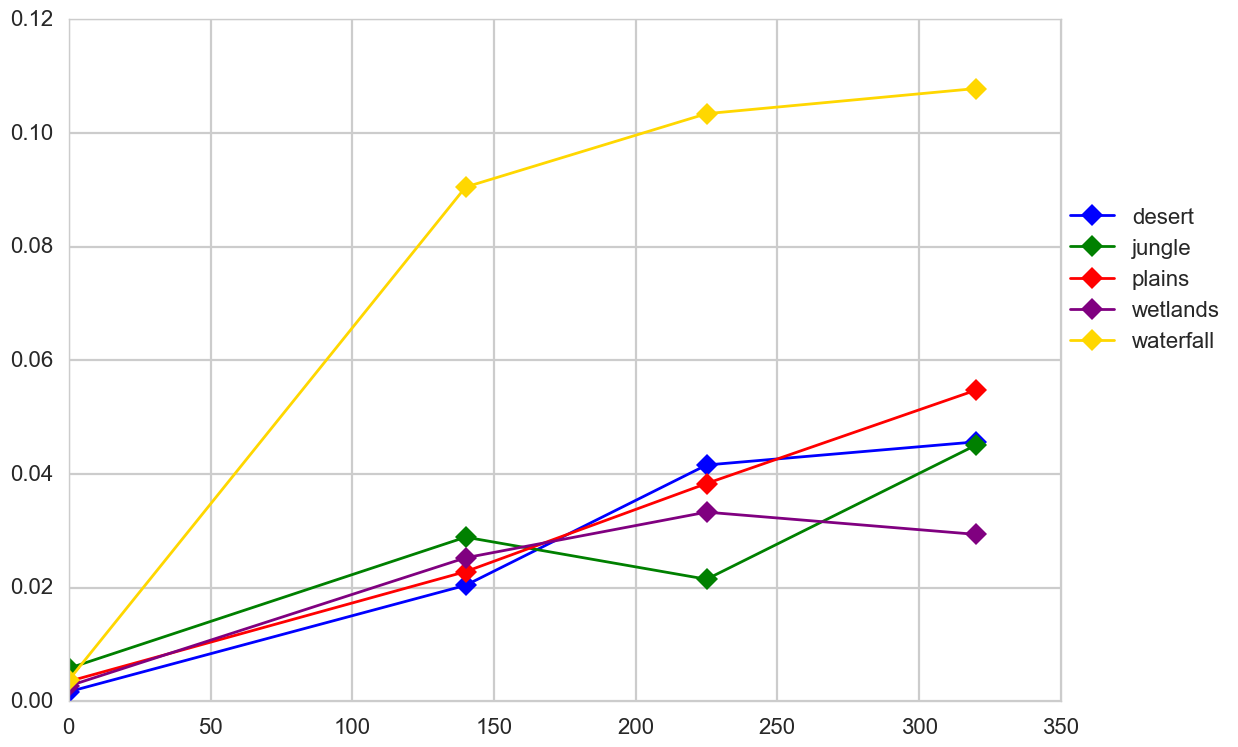

In [271]:
fig, ax = plt.subplots(1,1)

targets = [[],[],[],[],[],[]]
for i in range(len(cutoffs)):
    
    for j in range(5):
        
        targets[j].append(thetas[i][j])
    
    targets[5].append(thetas[i][5])

for i in range(5):  
    ax.plot(cutoffs, np.array(targets[i]) * np.array(targets[5]), '-D', c=c[i], label=labels[i], lw=2)
        
ax.legend(loc=[1,0.5])
plt.show()

In [272]:
thetas

[array([ 0.2430918 ,  0.83081712,  0.50295725,  0.38765233,  0.53547644,
         0.00702255,  0.1       ,  0.1       ]),
 array([ 0.2717569 ,  0.38450362,  0.30378291,  0.33617317,  1.20378336,
         0.0751867 ,  0.1       ,  0.1       ]),
 array([ 0.43667534,  0.22566376,  0.4024977 ,  0.34962805,  1.08553514,
         0.09527082,  0.1       ,  0.1       ]),
 array([ 0.40378443,  0.39864856,  0.484183  ,  0.25992008,  0.95346391,
         0.11310529,  0.1       ,  0.1       ])]